In [1]:
%matplotlib inline
import sys
BIN = '../../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms
import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from fastai import data_block, basic_train, basic_data
import fastai

In [2]:
import utils

In [3]:
from my_nn_modules import AE_basic, AE_bn, AE_LeakyReLU, AE_bn_LeakyReLU

In [4]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/aod/scaled_all_jets_partial_train.pkl')
test = pd.read_pickle(BIN + 'processed_data/aod/scaled_all_jets_partial_test.pkl')

train_small = train.sample(frac=0.1).reset_index(drop=True)  # Pick out a fraction of the data
test_small = test.sample(frac=0.1).reset_index(drop=True)

n_features = len(train.loc[0])
train

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,0.502144,0.896459,-0.210216,0.526104,0.513547,0.897240,0.551905,-0.213360,0.581632,0.548855,...,0.695516,0.720331,0.258285,0.107736,-0.615023,-0.892404,0.979556,0.018202,-0.998902,-0.998902
1,-0.074791,0.343298,-0.622855,0.421056,-0.004548,0.347707,0.342089,-0.623060,0.265149,-0.461181,...,-0.974998,-0.279938,-0.026481,0.027039,0.940342,0.085097,-0.945960,0.573317,0.215686,0.443584
2,0.969083,0.061602,-0.699887,0.840019,0.279324,0.065825,0.508655,-0.696762,0.415754,-0.789700,...,0.817306,0.906821,0.126189,0.969380,-0.615023,-0.788472,-0.945960,0.020174,-0.188247,-0.481644
3,0.077563,0.702864,0.072168,-0.095309,-0.670868,0.703087,-0.512803,0.069192,-0.528224,-0.698790,...,0.638965,0.339299,0.982104,0.688447,-0.383182,-0.748775,0.732944,-0.774204,0.395385,0.143415
4,-0.627654,0.465479,-0.459024,-0.763080,-0.964321,0.427865,-0.944639,-0.451359,-0.961828,0.147917,...,0.966758,-0.889688,0.384149,-0.336936,-0.615023,-0.578246,-0.945960,-0.843554,0.727270,0.779376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10751244,0.160031,-0.689627,0.894545,0.532320,0.977361,-0.707792,0.980403,0.890925,0.983090,-0.685082,...,-0.251777,0.095074,0.039789,-0.321022,-0.107903,0.123655,0.520287,0.786827,0.553878,0.356553
10751245,-0.458792,0.999153,0.059268,-0.973694,-0.286877,0.999150,-0.212045,0.053805,-0.126528,-0.999981,...,0.655789,-0.999777,-0.593803,-0.996674,-0.999981,-0.896791,-0.945960,-0.179727,-0.999981,-0.999981
10751246,0.423016,-0.228969,-0.226567,0.486966,-0.286877,-0.227844,-0.243831,-0.224036,-0.019029,-0.652775,...,0.647258,0.315332,0.604288,0.847172,0.441872,-0.468187,-0.945960,-0.088061,-0.132639,0.349682
10751247,-0.312396,0.470881,-0.998237,0.112105,0.513547,0.466604,0.688446,-0.987233,0.521857,0.111845,...,-0.963894,-0.573886,-0.621751,0.183483,0.649661,0.760025,-0.945960,-0.242089,0.156567,0.273763


In [5]:
bs = 128
# Create TensorDatasets
train_ds = TensorDataset(torch.tensor(train.values, dtype=torch.float), torch.tensor(train.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test.values, dtype=torch.float), torch.tensor(test.values, dtype=torch.float))
# Create DataLoaders
train_dl, valid_dl = utils.get_data(train_ds, valid_ds, bs=bs)
# Return DataBunch
db = basic_data.DataBunch(train_dl, valid_dl)

In [6]:
bs = 128
# Create TensorDatasets
small_train_ds = TensorDataset(torch.tensor(train_small.values, dtype=torch.float), torch.tensor(train_small.values, dtype=torch.float))
small_valid_ds = TensorDataset(torch.tensor(test_small.values, dtype=torch.float), torch.tensor(test_small.values, dtype=torch.float))
# Create DataLoaders
small_train_dl, small_valid_dl = utils.get_data(small_train_ds, small_valid_ds, bs=bs)
# Return DataBunch
small_db = basic_data.DataBunch(small_train_dl, small_valid_dl)

In [7]:
n_inputs = len(train.columns)
n_inputs

27

In [8]:
latent_dim = 20
nodes = [n_inputs, 100, 100, 100, latent_dim, 100, 100, 100, n_inputs]
model = AE(nodes=nodes, no_last_bias=False)
model_small = AE(nodes=nodes, no_last_bias=False)
model.train()

AE_bn(
  (encoder): Sequential(
    (0): Linear(in_features=27, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Tanh()
    (9): Linear(in_features=100, out_features=20, bias=True)
    (10): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, mo

In [9]:
loss_func = nn.MSELoss()

In [10]:
wd = 1e-6
from fastai.callbacks import ActivationStats
learn_small = basic_train.Learner(data=small_db, model=model_small, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, true_wd=True)

In [11]:
from fastai.callbacks import ActivationStats
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, true_wd=True)

In [12]:
from fastai import train as tr
tr.lr_find(learn, stop_div=True, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


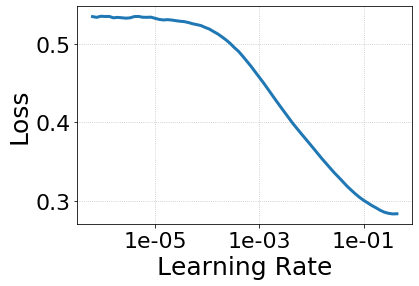

In [13]:
learn.recorder.plot()

In [14]:
lr = 1e-2
learn.fit_one_cycle(1, max_lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.001568,0.000919,1:15:15


Text(0.5, 0, 'Batches processed')

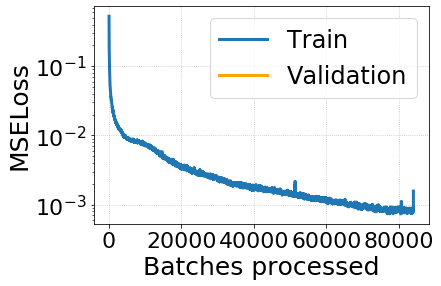

In [15]:
batches = len(learn.recorder.losses)
epos = len(learn.recorder.val_losses)
val_iter = (batches / epos) * np.arange(1, epos + 1, 1)
loss_name = str(loss_func).split("(")[0]
plt.figure()
plt.plot(learn.recorder.losses, label='Train')
plt.plot(val_iter, learn.recorder.val_losses, label='Validation', color='orange')
plt.yscale(value='log')
plt.legend()
plt.ylabel(loss_name)
plt.xlabel('Batches processed')

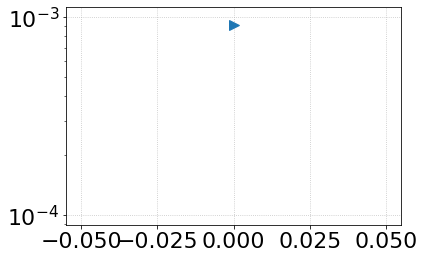

In [16]:
plt.plot(learn.recorder.val_losses, marker='>')
plt.yscale('log')

In [17]:
learn.activation_stats.modules

[Linear(in_features=27, out_features=100, bias=True),
 BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=100, out_features=100, bias=True),
 BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=100, out_features=100, bias=True),
 BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=100, out_features=20, bias=True),
 BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=20, out_features=100, bias=True),
 BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=100, out_features=100, bias=True),
 BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=100, out_features=100, bias=True),
 BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=100, out_features=

/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


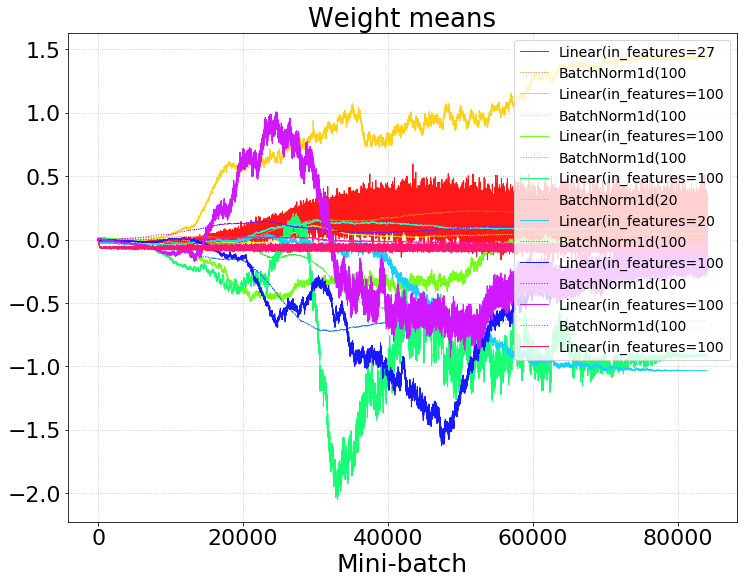

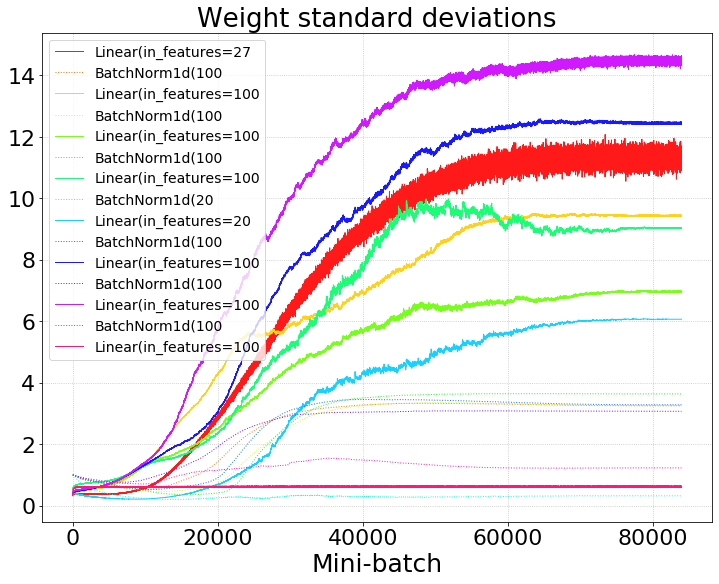

In [18]:
utils.plot_activations(learn)

In [19]:
import pickle
with open('transforms_save_dict.pkl', 'rb') as f:
    tfsms = pickle.load(f)

In [20]:
tfsms.keys()

dict_keys(['scaling_encode_transform', 'scaling_decode_transform'])

In [21]:
data = test
pred = model(torch.tensor(data.values, dtype=torch.float))

In [22]:
unscaled_pred = tfsms['scaling_decode_transform'](pred)

In [23]:
def plot_all(data, pred, logy=False, alph=0.8):
    for key in data.keys():
        plt.figure()
        n, bin_edges, _ = plt.hist(data[key], bins=80, color='c', label='Input', alpha=alph)
        plt.hist(pred[key], bins=bin_edges, color='orange', label='Output', alpha=alph)
        plt.legend()
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            ms.sciy()

In [24]:
unscaled_pred_df = pd.DataFrame(unscaled_pred, columns=test.columns)

In [25]:
pred_df = pd.DataFrame(pred.detach().numpy(), columns=test.columns)

/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


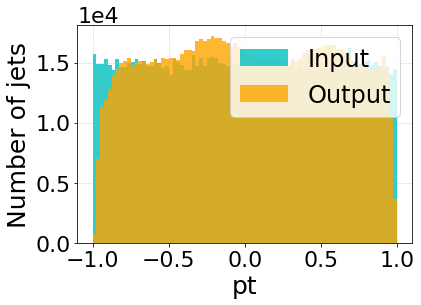

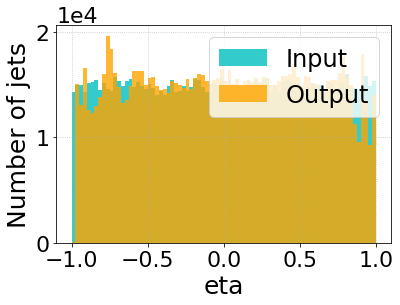

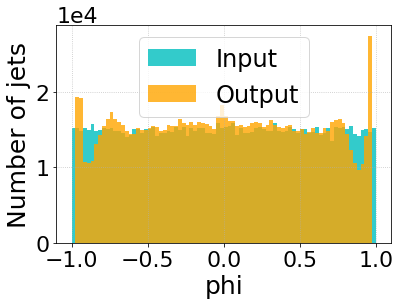

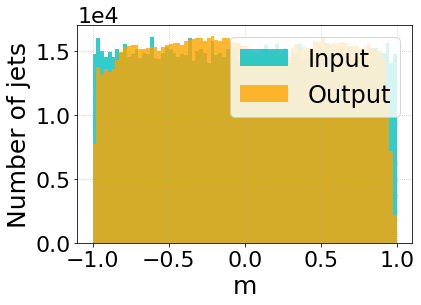

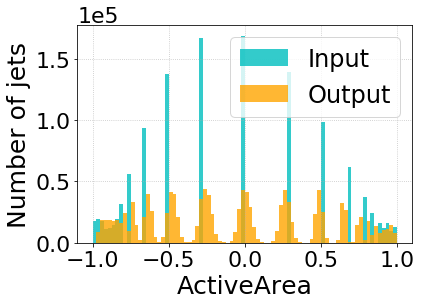

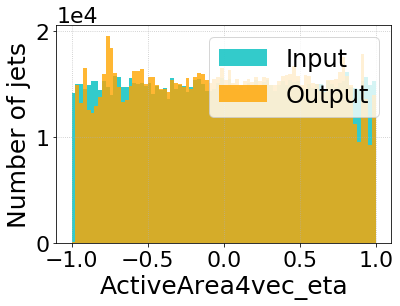

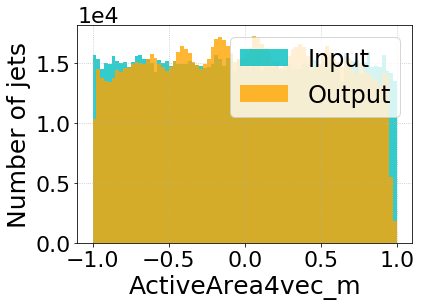

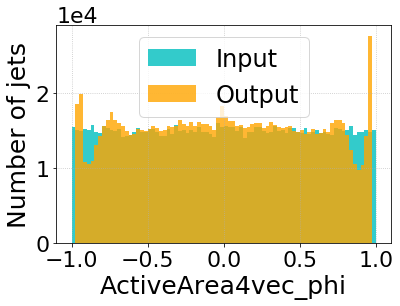

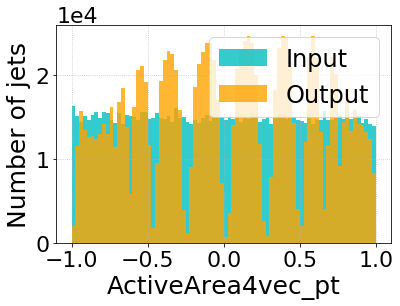

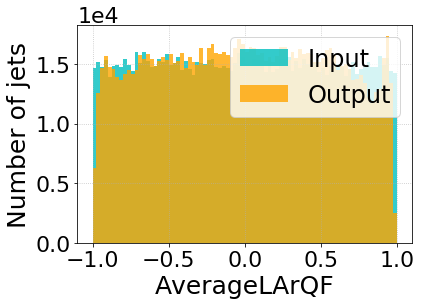

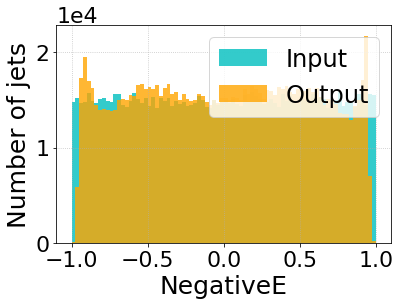

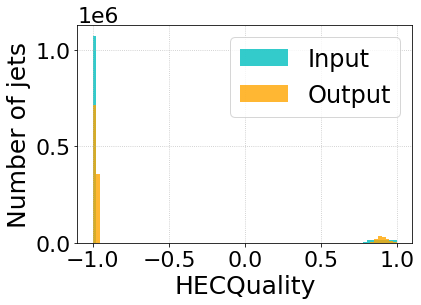

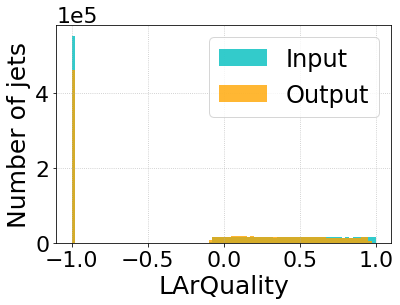

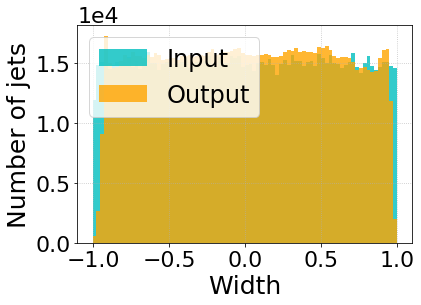

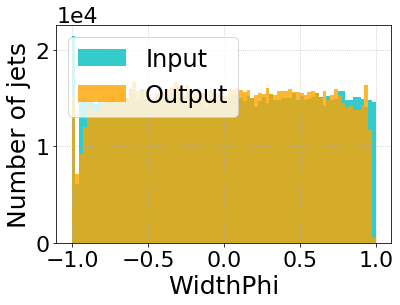

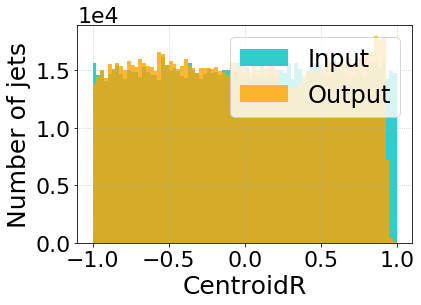

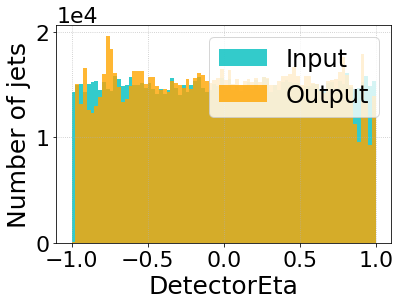

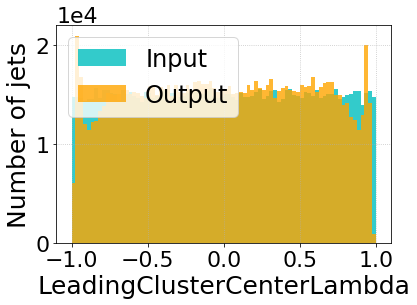

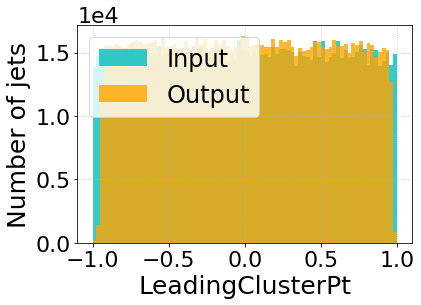

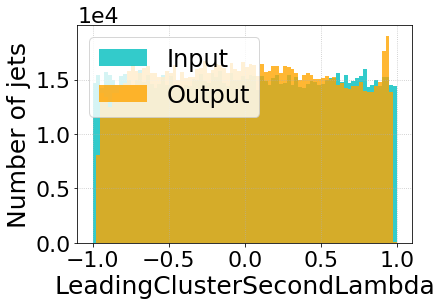

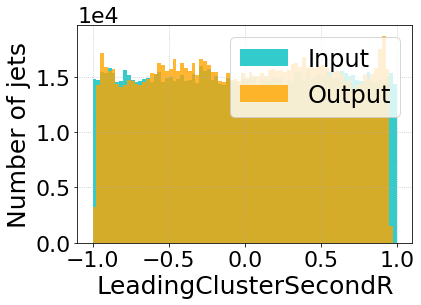

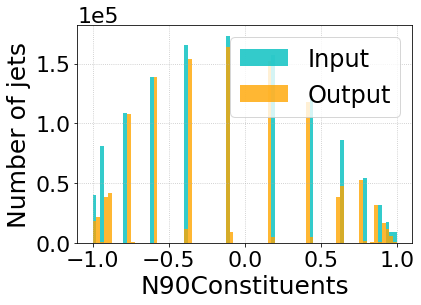

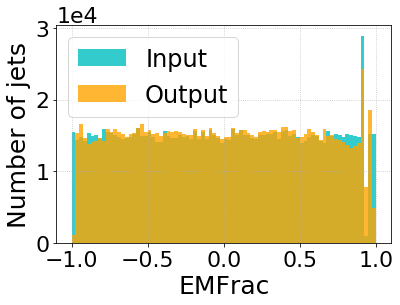

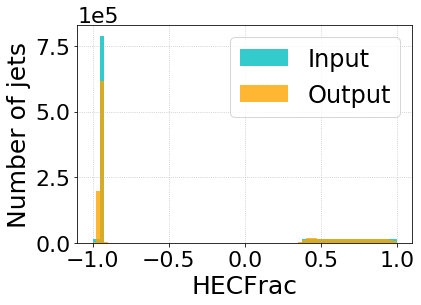

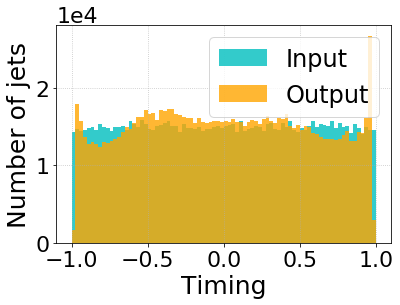

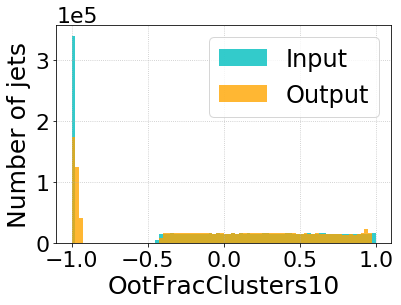

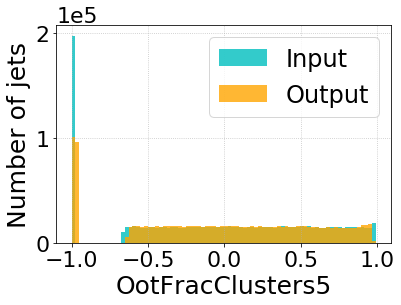

In [26]:
plot_all(data=data, pred=pred_df, logy=False)

In [27]:
lr = 1e-2
learn_small.fit_one_cycle(10, max_lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.007938,0.004629,07:38
1,0.004696,0.005199,06:36
2,0.002871,0.006901,06:36
3,0.002161,0.008833,06:44
4,0.001859,0.013192,05:44
5,0.001497,0.012582,05:48
6,0.001281,0.003694,05:48
7,0.001042,0.002358,05:47
8,0.000879,0.001016,05:49
9,0.000833,0.000611,05:47
